In [65]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from keras.initializers import Constant
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [39]:
df = pd.read_csv('covid_faq.csv')
df.head()

,questions,answers
0,What is a novel coronavirus?,A novel coronavirus is a new coronavirus that ...
1,Why is the disease being called coronavirus di...,"On February 11, 2020 the World Health Organiza..."
2,How does the virus spread?,The virus that causes COVID-19 is thought to s...
3,Can I get COVID-19 from food (including restau...,Currently there is no evidence that people can...
4,Will warm weather stop the outbreak of COVID-19?,It is not yet known whether weather and temper...


In [40]:
df.shape

(117, 2)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   questions  117 non-null    object
 1   answers    117 non-null    object
dtypes: object(2)
memory usage: 2.0+ KB


In [42]:
df.isnull().sum()

questions    0
answers      0
dtype: int64

In [43]:
df.duplicated().sum()

np.int64(0)

In [44]:
df['intent'] = range(df.shape[0])

In [45]:
df.head()

,questions,answers,intent
0,What is a novel coronavirus?,A novel coronavirus is a new coronavirus that ...,0
1,Why is the disease being called coronavirus di...,"On February 11, 2020 the World Health Organiza...",1
2,How does the virus spread?,The virus that causes COVID-19 is thought to s...,2
3,Can I get COVID-19 from food (including restau...,Currently there is no evidence that people can...,3
4,Will warm weather stop the outbreak of COVID-19?,It is not yet known whether weather and temper...,4


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   questions  117 non-null    object
 1   answers    117 non-null    object
 2   intent     117 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 2.9+ KB


In [47]:
num_classes = df['intent'].nunique()
num_classes

117

In [48]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['questions'])
seq = tokenizer.texts_to_sequences(df['questions'])

In [49]:
maxlen = max([len(i) for i in seq])

In [50]:
maxlen

38

In [51]:
vocab_size = len(tokenizer.word_index) + 1

In [52]:
vocab_size

421

In [53]:
pad_seq = pad_sequences(seq, maxlen = maxlen, padding = 'post')

In [54]:
pad_seq

array([[  9,  10,  11, ...,   0,   0,   0],
       [ 89,  10,   4, ...,   0,   0,   0],
       [ 16,  69,   4, ...,   0,   0,   0],
       ...,
       [ 28, 399,  12, ...,   1,   2, 110],
       [  5, 407, 408, ...,   0,   0,   0],
       [ 16,   5,   4, ...,   0,   0,   0]], dtype=int32)

In [55]:
glove_file = open('glove.6B.100d.txt', encoding = 'utf-8')
embedding_matrix = dict()
for line in glove_file:
    record = line.split()
    word = record[0]
    vector = np.asarray(record[1: ], dtype = 'float32')
    embedding_matrix[word] = vector
glove_file.close()

In [56]:
embedding_vectors = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    vec = embedding_matrix.get(word)
    if vec is not None:
        embedding_vectors[index] = vec

In [57]:
embedding_vectors

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.43504   , -0.15881   , -0.10007   , ..., -0.14538001,
         0.22725999, -0.65627998],
       ...,
       [ 0.57060999, -0.18872   ,  0.015074  , ...,  0.44003001,
         0.38679001, -0.056279  ],
       [ 0.14661001,  0.23266   , -0.38536999, ...,  0.21637   ,
        -0.22292   ,  0.42914999],
       [ 0.14210001,  0.63458002, -0.80778998, ..., -0.05491   ,
         0.48669001,  0.38824001]])

In [58]:
model = Sequential()

In [59]:
model.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model.add(Bidirectional(LSTM(15)))
model.add(Dense(num_classes, activation = 'softmax'))

In [60]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [61]:
y = df['intent']

In [62]:
early_stopping = EarlyStopping(monitor = 'loss', patience = 7)

In [63]:
history = model.fit(pad_seq, y, epochs = 150, callbacks = [early_stopping])

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.0000e+00 - loss: 4.7684
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0000e+00 - loss: 4.7559
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0000e+00 - loss: 4.7484
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0086 - loss: 4.7432    
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0110 - loss: 4.7324   
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0204 - loss: 4.7148
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0358 - loss: 4.7119
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0400 - loss: 4.6961
Epoch 9/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0601 - loss: 4.6789
Epoch 10/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0604 - loss: 4.6706
Epoch 11/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0596 - loss: 4.6496
Epoch 12/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - ac

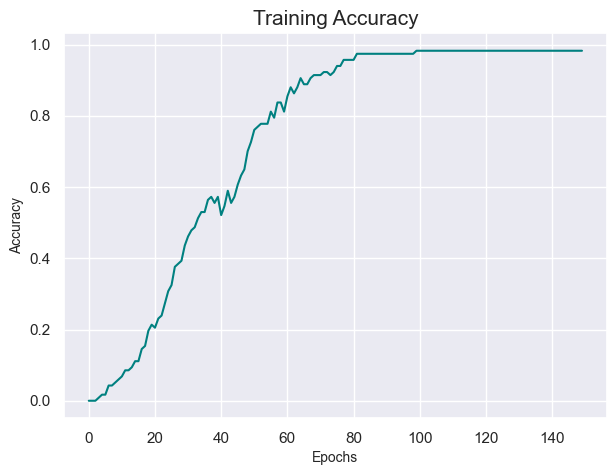

In [66]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['accuracy'], color = 'teal')
plt.title('Training Accuracy', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.show()

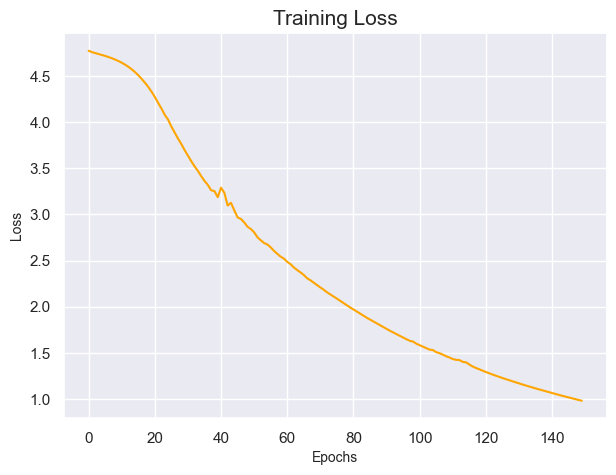

In [67]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['loss'], color = 'orange')
plt.title('Training Loss', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.show()

In [102]:
resp_list = df['answers']

In [104]:
te = 'How does the virus spread?'
te_seq = tokenizer.texts_to_sequences([te])[0]
pad_te = pad_sequences([te_seq], maxlen = maxlen, padding = 'post')
pred = np.argmax(model.predict(pad_te))
print(resp_list[pred])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
The virus that causes COVID-19 is thought to spread mainly from person to person, mainly through respiratory droplets produced when an infected person coughs, sneezes, or talks. These droplets can land in the mouths or noses of people who are nearby or possibly be inhaled into the lungs. Spread is more likely when people are in close contact with one another (within about 6 feet). COVID-19 seems to be spreading easily and sustainably in the community (“community spread”) in many affected geographic areas. Community spread means people have been infected with the virus in an area, including some who are not sure how or where they became infected.


In [111]:
df['questions'][0]

'What is a novel coronavirus?'

In [112]:
df['questions'][1]

'Why is the disease being called coronavirus disease 2019, COVID-19?'

In [113]:
df['questions'][2]

'How does the virus spread?'

In [114]:
df['questions'][3]

'Can I get COVID-19 from food (including restaurant take-out, produce, refrigerated, or packaged food) or drinking water?'

In [115]:
df['questions'][4]

'Will warm weather stop the outbreak of COVID-19?'

In [116]:
df['questions'][5]

'What is community spread?'

In [117]:
df['questions'][6]

'Can mosquitoes or ticks spread the virus that causes COVID-19?'

In [119]:
while True:
    input_text = input('You: ')
    if input_text == 'finish':
        break
    else:
        text_seq = tokenizer.texts_to_sequences([input_text])[0]
        pad_text = pad_sequences([text_seq], maxlen = maxlen, padding = 'post')
        prediction = np.argmax(model.predict(pad_text))
        print('Bot: ', '\n', resp_list[prediction])
        print('==============================================================================================================')

You:  What is a novel coronavirus?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Bot:  
 A novel coronavirus is a new coronavirus that has not been previously identified. The virus causing coronavirus disease 2019 (COVID-19), is not the same as the coronaviruses that commonly circulate among humans and cause mild illness, like the common cold.


You:  a novel coronavirus?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Bot:  
 A novel coronavirus is a new coronavirus that has not been previously identified. The virus causing coronavirus disease 2019 (COVID-19), is not the same as the coronaviruses that commonly circulate among humans and cause mild illness, like the common cold.


You:  Why is the disease being called coronavirus disease 2019, COVID-19?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Bot:  
 On February 11, 2020 the World Health Organization announced an official name for the disease that is causing the 2019 novel coronavirus outbreak, first identified in Wuhan China. The new name of this disease is coronavirus disease 2019, abbreviated as COVID-19. In COVID-19, ‘CO’ stands for ‘corona,’ ‘VI’ for ‘virus,’ and ‘D’ for disease. Formerly, this disease was referred to as “2019 novel coronavirus” or “2019-nCoV”. There are many types of human coronaviruses including some that commonly cause mild upper-respiratory tract illnesses. COVID-19 is a new disease, caused by a novel (or new) coronavirus that has not previously been seen in humans.


You:  How does the virus spread?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Bot:  
 The virus that causes COVID-19 is thought to spread mainly from person to person, mainly through respiratory droplets produced when an infected person coughs, sneezes, or talks. These droplets can land in the mouths or noses of people who are nearby or possibly be inhaled into the lungs. Spread is more likely when people are in close contact with one another (within about 6 feet). COVID-19 seems to be spreading easily and sustainably in the community (“community spread”) in many affected geographic areas. Community spread means people have been infected with the virus in an area, including some who are not sure how or where they became infected.


You:  the virus


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Bot:  
 The virus that causes COVID-19 is thought to spread mainly from person to person, mainly through respiratory droplets produced when an infected person coughs, sneezes, or talks. These droplets can land in the mouths or noses of people who are nearby or possibly be inhaled into the lungs. Spread is more likely when people are in close contact with one another (within about 6 feet). COVID-19 seems to be spreading easily and sustainably in the community (“community spread”) in many affected geographic areas. Community spread means people have been infected with the virus in an area, including some who are not sure how or where they became infected.


You:  Will warm weather stop the outbreak of COVID-19?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Bot:  
 It is not yet known whether weather and temperature affect the spread of COVID-19. Some other viruses, like those that cause the common cold and flu, spread more during cold weather months but that does not mean it is impossible to become sick with these viruses during other months. There is much more to learn about the transmissibility, severity, and other features associated with COVID-19 and investigations are ongoing.


You:  What is community spread?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Bot:  
 Community spread means people have been infected with the virus in an area, including some who are not sure how or where they became infected. Each health department determines community spread differently based on local conditions. For information on community spread in your area, please visit your health department’s website.​


You:  finish
